---
# This Notebook is for the purpose of comparing the FINESSE modeling framework to the LCT framework
---
<div style="text-align: right"> Written by Lane Scheel, 2024 </div>

In [1]:
import finesse
import numpy as np
import cmath
import time
import imageio
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib import cm
import finesse.components as components
import finesse.detectors as detectors
import finesse.analysis as analysis
import finesse.tracing as tracing
import finesse.gaussian as gaussian
import finesse.thermal.hello_vinet as hv
from finesse.knm import Map
from finesse.materials import FusedSilica
from finesse.utilities.maps import circular_aperture
from scipy.sparse.linalg import ArpackNoConvergence
from scipy.sparse import csc_matrix
import math
from matplotlib import colormaps
from matplotlib.patches import Patch
import scipy.sparse.linalg
import scipy.optimize
import cleaned_annotated_LCT_functions as lctf
import cleaned_annotated_optical_functions as of

---
# This first model will be the LCT
---

In [2]:
'''
 Define the Transmittance and Reflectance
 of the two mirrors (Input/End Test Masses)
'''
T_ITM = 0.014
T_ETM = 5e-6
R_ITM = 1 - T_ITM
R_ETM = 1 - T_ETM

'''
Calculate the Transmittance
and Reflectance coefficients
'''
t_ITM = np.sqrt(T_ITM)
t_ETM = np.sqrt(T_ETM)
r_ITM = np.sqrt(R_ITM)
r_ETM = np.sqrt(R_ETM)

'''
Define the radius of curvature of the two
mirrors, the optical cavity length, and
the radius of the two mirrors.
'''
RoC_ITM = 1934
RoC_ETM = 2245
len_ARM = 3994.5
TM_aperture_diam = 32.6e-2
TM_aperture_radius = TM_aperture_diam/2

'''
Using the custom abcd functions, we 
can easily define complete abcd matrices
for each part of the optical system.
'''
md = of.set_space(len_ARM)
m1 = of.set_mirror(RoC_ITM)
m2 = of.set_mirror(RoC_ETM)

'''
Define the round trip reflectance coefficient,
the round trip ABCD matrix, the eigenmodes of 
the cavity, and the accumulated gouy phase
through the round trip ABCD matrix
'''
r_rt = r_ITM*r_ETM
m_rt = m1@md@m2@md
q_eig = of.calc_q_eig(m_rt)
g_rt = of.calc_accum_gouy_nm(q_eig, m_rt, n=0, m=0)
waist = of.get_waist(q_eig)

'''
The dimensions of our NxM cartesian grid.
The larger the grid, the better the resolution.
The larger the grid, the more compute time.
'''
N, M = 256, 256

'''
The q-parameter of the input beam.
Set equal to the eigenmode of the cavity
for a perfect mode match.
'''
q_inc = q_eig

'''
Propagate the beam parameter q_inc
from the first mirror to the second.
This is so we can calculate the spot 
size of the beam at each end.
'''
q_to_ETM = of.prop_beam_param(q_inc, md)

'''
Calculate the beam spot width at each of
the mirrors in units of meters
'''
w_ITM = of.get_width(q_inc)
w_ETM = of.get_width(q_to_ETM)
'''
Define our x-array and y-array for
plotting the cartesian grid of the ITM.
Scale defines how zoomed to the spot we
want the plot to be. Bigger is farther.
*NOTE: multiplying by w_ETM rather than 
w_ITM ensure any resulting plots are at
the same absolute dimension*
'''
scale = 5
xs_ITM = np.linspace(-1, 1, N) * scale*w_ETM
ys_ITM = np.linspace(-1, 1, M) * scale*w_ETM

'''
Define our x-array and y-array for
plotting the cartesian grid of the ETM
Scale defines how zoomed to the spot we
want the plot to be. Bigger is farther.
'''
scale = 5
xs_ETM = np.linspace(-1, 1, N) * scale*w_ETM
ys_ETM = np.linspace(-1, 1, M) * scale*w_ETM

'''
Define the delta-x,y, or space between each
sampled point on each axis for the ITM
'''
dx_ITM = xs_ITM[1] - xs_ITM[0]
dy_ITM = ys_ITM[1] - ys_ITM[0]

'''
Define the delta-x,y, or space between each
sampled point on each axis for the ETM
'''
dx_ETM = xs_ETM[1] - xs_ETM[0]
dy_ETM = ys_ETM[1] - ys_ETM[0]

'''
Define the input power of the laser (W)
A single LIGO arm cavity is recieving
~2600 W of power from the beam splitter.
'''
P_in = 2600

'''
Define what the incident field looks like by
first computing the raw field modes. Then, sum
them together in the beam and scale it properly.
'''
u00 = of.get_2D_field_amp_nm(xs_ITM, ys_ITM, q_inc, q_inc, 0, 0)
u06 = of.get_2D_field_amp_nm(xs_ITM, ys_ITM, q_inc, q_inc, 0, 6)
u01 = of.get_2D_field_amp_nm(xs_ITM, ys_ITM, q_inc, q_inc, 0, 1)
# input beam is equal parts hg00, hg01, and hg06 as in the paper
U_inc = u00 + u01 + u06
U_inc /= np.sqrt(np.sum(np.abs(U_inc)**2)*dx_ETM*dy_ETM) / np.sqrt(P_in)
#U_inc = np.sqrt(P_in) * of.get_2D_field_amp_nm(xs_ITM, ys_ITM, q_inc, q_inc, 0, 0)

'''
First define an array of 1s the same size as our grid
'''
ap_map_ITM = np.ones([M, N], dtype=float)
ap_map_ETM = np.ones([M, N], dtype=float)

'''
Declare that any point on the grid not within
the mirror aperature be set to zero
'''
ap_map_ITM[np.add.outer(ys_ITM**2, xs_ITM**2) > TM_aperture_radius**2] = 0
ap_map_ETM[np.add.outer(ys_ETM**2, xs_ETM**2) > TM_aperture_radius**2] = 0

'''
First we define the propagation operators in the x and y directions.
These will operate on the input beam, and represent the change the
beam goes through while traveling through the empty space of the cavity.
'''
D_x_ITM_to_ETM = lctf.DLCT(xs_ITM, xs_ETM, M_abcd=md) # ITM -> ETM (x)
D_y_ITM_to_ETM = lctf.DLCT(ys_ITM, ys_ETM, M_abcd=md) # ITM -> ETM (y)
D_x_ETM_to_ITM = lctf.DLCT(xs_ETM, xs_ITM, M_abcd=md) # ETM -> ITM (x)
D_y_ETM_to_ITM = lctf.DLCT(ys_ETM, ys_ITM, M_abcd=md) # ETM -> ITM (y)

'''
Now we define the reflection operators that account for the curved
surface of the mirrors. This is done with a chirp function. They 
will operate on the circulating beam, and represent the change the
beam goes through while reflecting off the mirrors.
'''
C_x_ETM = lctf.CM_kernel(xs_ETM, -2/RoC_ETM, diag=True)
C_y_ETM = lctf.CM_kernel(ys_ETM, -2/RoC_ETM, diag=True)
C_x_ITM = lctf.CM_kernel(xs_ITM, -2/RoC_ITM, diag=True)
C_y_ITM = lctf.CM_kernel(ys_ITM, -2/RoC_ITM, diag=True)

'''
Combine the x and y components of each mirror operator into one.
'''
Rc_map_ETM = np.outer(C_y_ETM, C_x_ETM)
Rc_map_ITM = np.outer(C_y_ITM, C_x_ITM)

'''
This function defines a round-trip operator and then
flattens it to pass to the linear operator constructor.
'''
def op_rt_eig(v):
    Xin = np.reshape(v, [M,N])
    X1 = D_y_ITM_to_ETM@Xin@D_x_ITM_to_ETM.T
    X2 = ap_map_ETM*Rc_map_ETM*X1 #ap_map_ETM*
    X3 = D_y_ETM_to_ITM@X2@D_x_ETM_to_ITM.T
    X4 = ap_map_ITM*Rc_map_ITM*X3 #ap_map_ITM*
    return np.ravel(X4)

'''
This scipy function acts as a linear operator constructor.
It takes our predefined operator (in the form of a flattened
1D array), and turns it into an array of shape N*M x N*M.
This will then be used to compute the eigen-stuff of the cavity.
'''
linop_rt_eig = scipy.sparse.linalg.LinearOperator(matvec=op_rt_eig, shape=[N*M,N*M])

'''
This calculates the incident field after propagation through ITM.
'''
U_inc_at_ITM = U_inc * 1j * t_ITM * ap_map_ITM

'''
This neatly turns the input field into a 1D array so that we can 
operate on it with the circulating linear operator.
'''
U_in = np.ravel(U_inc_at_ITM)

In [3]:
'''
Define the number resolution of our scan,
the extent of our scan, and the output array.
NOTE: By "extent of our scan" is meant how much
will the placement of the ETM change. Are are not
simply adding a flat length to the round trip distance.
'''
Nphi = 1601
phis_plot = np.linspace(-20, 380, Nphi)
out = np.zeros([Nphi, M, N], dtype=np.complex128)

'''
The following will do the exact same things as was done early,
but it will do so in an iterative fashion over the range of 
phis we have defined. It also has a fancy percentage completion.
'''
for k, phi in enumerate(phis_plot):
    print(f'Cavity Scan {(k+1)/Nphi*100 :0.2f}% Complete', end=' '*90+'\r')
    g = np.exp(2j*phi/180*np.pi)
    
    # normalize the eigenvalue to use it for putting the cavity on resonance
    cavity_phase_tuning = np.conj(g_rt)

    def op_rt(v):
        '''Round trip operator. Put in mirror reflectivities and put the cavity on resonance.
        '''
        Xin = np.reshape(v, [M,N])
        X1 = D_y_ITM_to_ETM@Xin@D_x_ITM_to_ETM.T
        X2 = ap_map_ETM*Rc_map_ETM*X1*r_ETM #ap_map_ETM*
        X3 = D_y_ETM_to_ITM@X2@D_x_ETM_to_ITM.T
        X4 = ap_map_ITM*Rc_map_ITM*X3*r_ITM*cavity_phase_tuning*g #ap_map_ITM*
        return np.ravel(X4)

    def op_circ(v):
        '''Circulating operator is identity operator minus round trip operator.
        '''
        return v - op_rt(v)

    linop_circ = scipy.sparse.linalg.LinearOperator(matvec=op_circ, shape=[N*M,N*M])
    U_circ, _ = scipy.sparse.linalg.gmres(linop_circ, U_in)
    
    out[k,:,:] = np.reshape(U_circ, [M,N])

'''
This calculates the power of the beam at each phi step,
and puts it in a neat array for the purpose of plotting.
'''
cavity_scan = np.sum(np.sum(np.abs(out)**2, axis=1), axis=1)*dy_ETM*dx_ETM

---
# The following model will be FINESSE
---

In [5]:
# These are the aperature maps for FINESSE, stuck here because I'm borrowing from the ITM
FINESSE_ap_map_ITM = Map(
    xs_ITM,
    ys_ITM,
    amplitude=ap_map_ITM
)

FINESSE_ap_map_ETM = Map(
    xs_ETM,
    ys_ETM,
    amplitude=ap_map_ETM
)

# Name and declare your new FINESSE model
###########################################################################################################################
LIGO_arm = finesse.Model()
###########################################################################################################################

# Build your FINESSE model
###########################################################################################################################

# Add the laser
LIGO_arm.add(
    components.Laser(
        name="L0", P=2600, f=0, phase=0
    )
)

# Add the optical components
LIGO_arm.add([
    components.Mirror(
        name="ITM", R=1-0.014, T=0.014, L=0, phi=0, Rc=1934, xbeta=0, ybeta=0, misaligned=False
    ),
    components.Mirror(
        name="ETM", R=1-5e-6, T=5e-6, L=0, phi=0, Rc=2245, xbeta=0, ybeta=0, misaligned=False
    )]
)

# Add the spaces between things
LIGO_arm.add([
    components.Space(
        name="S0", portA=LIGO_arm.L0.p1, portB=LIGO_arm.ITM.p2, L=0, nr=1
    ),
    components.Space(
        name="CAV", portA=LIGO_arm.ITM.p1, portB=LIGO_arm.ETM.p1, L=3994.5, nr=1
    )]
)

# Add detectors and what-not
LIGO_arm.add([
    detectors.PowerDetector(
        name="CirculatingPower", node=LIGO_arm.ITM.p1.i
    ),
    detectors.PowerDetector(
        name="CirculatingPower2", node=LIGO_arm.ETM.p1.i
    )]
)

# Define cavities for propogating beam
LIGO_arm.add(
    components.Cavity(
        name="FP", source=LIGO_arm.ITM.p1.o
    )
)
###########################################################################################################################

# Define the max order of the the HG modes used in the simulation
###########################################################################################################################
LIGO_arm.modes(
    maxtem=24
)

LIGO_arm.L0.tem(0, 0, 1, phase=0)
LIGO_arm.L0.tem(0, 1, 1, phase=0)
LIGO_arm.L0.tem(0, 6, 1, phase=0)
###########################################################################################################################

# Random things
###########################################################################################################################
LIGO_arm.ITM.surface_map = FINESSE_ap_map_ITM
LIGO_arm.ETM.surface_map = FINESSE_ap_map_ETM
###########################################################################################################################

# Run a series of analysis on your FINESSE model
###########################################################################################################################
series_analysis = analysis.actions.series.Series(
    analysis.actions.axes.Xaxis(
        parameter=LIGO_arm.ETM.phi, mode='lin', start=-20, stop=380, steps=1600
    ),
    analysis.actions.beam.PropagateBeam(
        to_node=LIGO_arm.ETM.p1.i, from_node=LIGO_arm.ITM.p1.o, direction="y"
    )
)
###########################################################################################################################

# Run your model to get results
###########################################################################################################################
out_FINESSE = LIGO_arm.run(series_analysis)
###########################################################################################################################

---
# Now we compare the two
---

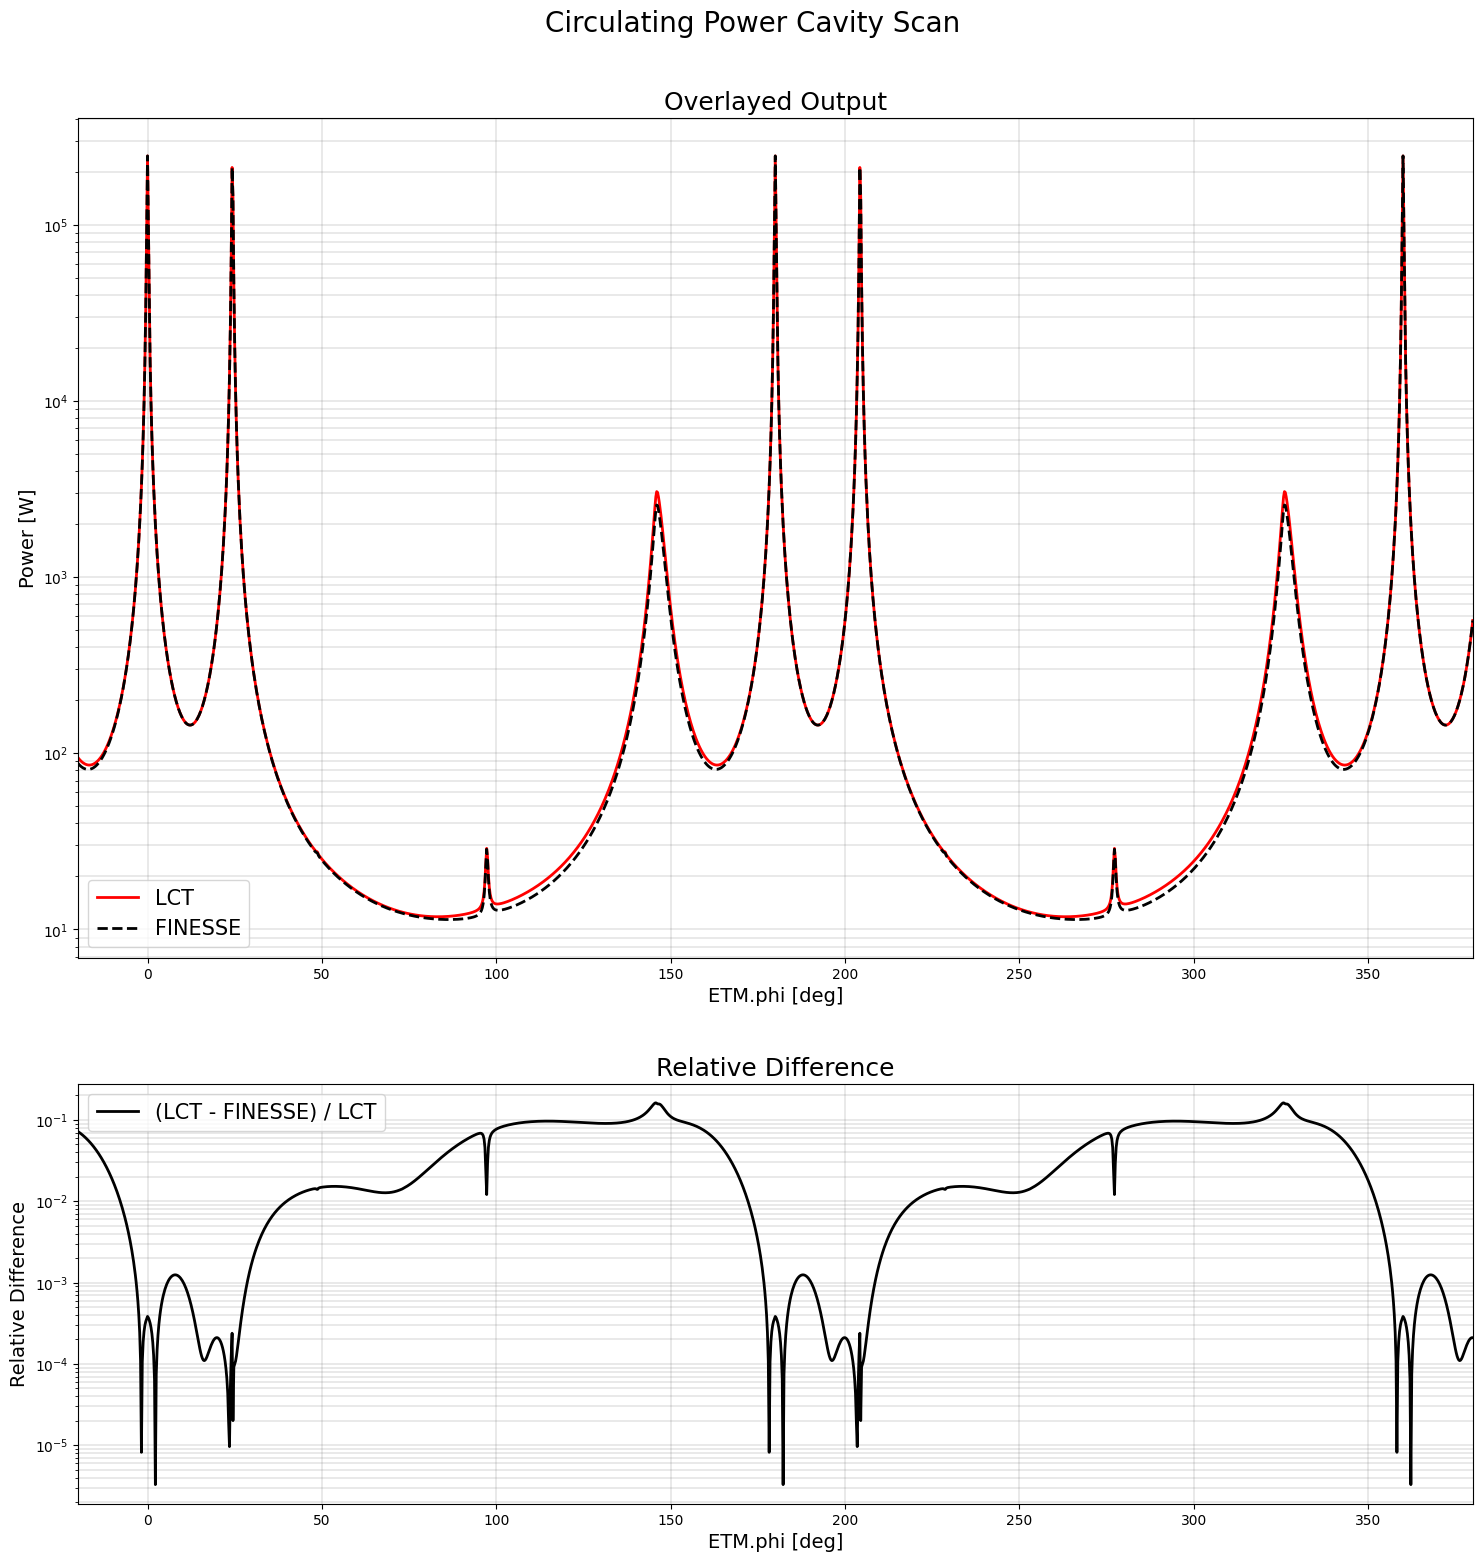

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(18, 18), gridspec_kw={'height_ratios': [2, 1]})

ax = axes[0]
ax.set_title("Overlayed Output", fontsize=18)
ax.plot(phis_plot, cavity_scan, ls='-', c='r', label='LCT', lw=2)
ax.plot(out_FINESSE['xaxis'].x[0], out_FINESSE['xaxis']['CirculatingPower'], ls='--', c='k', label='FINESSE', lw=2)
ax.set_ylabel(r"Power [W]", fontsize=14)
ax.set_xlabel(r"ETM.phi [deg]", fontsize=14)
ax.set_yscale('log')
ax.set_xlim(-20,380)
ax.grid(True, which='both', axis='both', color='gray', linestyle='-', linewidth=0.25)
ax.legend(fontsize=15)

ax = axes[1]
ax.set_title("Relative Difference", fontsize=18)
ax.plot(out_FINESSE['xaxis'].x[0], np.abs(cavity_scan-out_FINESSE['xaxis']['CirculatingPower'])/np.abs(cavity_scan), ls='-', c='k', label='(LCT - FINESSE) / LCT', lw=2)
ax.set_ylabel(r"Relative Difference", fontsize=14)
ax.set_xlabel(r"ETM.phi [deg]", fontsize=14)
ax.set_yscale('log')
ax.set_xlim(-20,380)
ax.grid(True, which='both', axis='both', color='gray', linestyle='-', linewidth=0.25)
ax.legend(fontsize=15)

plt.suptitle('Circulating Power Cavity Scan', y=0.94, fontsize=20)
plt.savefig('Media/LCTvsFINESSE_evenmoreHOMs.jpg')
plt.show()

In [24]:
maxtem00_absolute = np.array([])
maxtem00_relative = np.array([])
maxtem02_absolute = np.array([])
maxtem02_relative = np.array([])
maxtem04_absolute = np.array([])
maxtem04_relative = np.array([])
maxtem06_absolute = np.array([])
maxtem06_relative = np.array([])
maxtem08_absolute = np.array([])
maxtem08_relative = np.array([])
maxtem10_absolute = np.array([])
maxtem10_relative = np.array([])
maxtem12_absolute = np.array([])
maxtem12_relative = np.array([])
maxtem14_absolute = np.array([])
maxtem14_relative = np.array([])
maxtem16_absolute = np.array([])
maxtem16_relative = np.array([])
maxtem18_absolute = np.array([])
maxtem18_relative = np.array([])
maxtem20_absolute = np.array([])
maxtem20_relative = np.array([])

In [68]:
Xs_ITM, Ys_ITM = np.meshgrid(xs_ITM, ys_ITM)
R_ITM = np.sqrt(Xs_ITM**2 + Ys_ITM**2)

Xs_ETM, Ys_ETM = np.meshgrid(xs_ETM, ys_ETM)
R_ETM = np.sqrt(Xs_ETM**2 + Ys_ETM**2)

ITM_sdef_coat = hv.surface_deformation_coating_heating_HG00(
    r=xs_ITM, a=TM_aperture_radius, h=0.2, w=w_ITM, material=FusedSilica
)

ETM_sdef_coat = hv.surface_deformation_coating_heating_HG00(
    r=xs_ETM, a=TM_aperture_radius, h=0.2, w=w_ETM, material=FusedSilica
)

absorbed_power = np.linspace(0,1,11)

for power in absorbed_power:
    
    sdef_total_ITM = ITM_sdef_coat*power
    sdef_total_ETM = ETM_sdef_coat*power

    ITM_sdef_total = np.interp(R_ITM, xs_ITM, sdef_total_ITM)
    ETM_sdef_total = np.interp(R_ETM, xs_ETM, sdef_total_ETM)

    thermal_map_ITM = Map(
        xs_ITM,
        ys_ITM,
        opd=ITM_sdef_total,
        amplitude=ap_map_ITM
    )

    thermal_map_ETM = Map(
        xs_ETM,
        ys_ETM,
        opd=ETM_sdef_total,
        amplitude=ap_map_ETM
    )

    # Name and declare your new FINESSE model
    ###########################################################################################################################
    LIGO_arm = finesse.Model()
    ###########################################################################################################################

    # Build your FINESSE model
    ###########################################################################################################################

    # Add the laser
    LIGO_arm.add(
        components.Laser(
            name="L0", P=(power/(0.5e-6))/282.80379326802523, f=0, phase=0
        )
    )

    # Add the optical components
    LIGO_arm.add([
        components.Mirror(
            name="ITM", R=1-0.014, T=0.014, L=0, phi=0, Rc=1934, xbeta=0, ybeta=0, misaligned=False
        ),
        components.Mirror(
            name="ETM", R=1-5e-6, T=5e-6, L=0, phi=0, Rc=2245, xbeta=0, ybeta=0, misaligned=False
        )]
    )

    # Add the spaces between things
    LIGO_arm.add([
        components.Space(
            name="S0", portA=LIGO_arm.L0.p1, portB=LIGO_arm.ITM.p2, L=0, nr=1
        ),
        components.Space(
            name="CAV", portA=LIGO_arm.ITM.p1, portB=LIGO_arm.ETM.p1, L=3994.5, nr=1
        )]
    )

    # Add detectors and what-not
    LIGO_arm.add([
        detectors.PowerDetector(
            name="CirculatingPower", node=LIGO_arm.ITM.p1.i
        )]
    )

    # Define cavities for propogating beam
    LIGO_arm.add(
        components.Cavity(
            name="FP", source=LIGO_arm.ITM.p1.o
        )
    )
    ###########################################################################################################################

    # Define the max order of the the HG modes used in the simulation
    ###########################################################################################################################
    LIGO_arm.modes(
        maxtem=20
    )

    LIGO_arm.L0.tem(0, 0, 1, phase=0)
    ###########################################################################################################################

    # Random things
    ###########################################################################################################################
    original_ITM_diopter = 2 / (LIGO_arm.ITM.Rc)
    original_ETM_diopter = 2 / (LIGO_arm.ETM.Rc)

    new_ITM_Rcx, new_ITM_Rcy = thermal_map_ITM.get_radius_of_curvature_reflection(w_ITM)
    new_ETM_Rcx, new_ETM_Rcy = thermal_map_ETM.get_radius_of_curvature_reflection(w_ETM)

    new_avg_ITM_diopter = 2 / ((new_ITM_Rcx+new_ITM_Rcy)/2)
    new_avg_ETM_diopter = 2 / ((new_ETM_Rcx+new_ETM_Rcy)/2)

    thermal_map_ITM.remove_curvatures(w_ITM, mode="average")
    thermal_map_ETM.remove_curvatures(w_ETM, mode="average")

    LIGO_arm.ITM.Rc = 2 / (original_ITM_diopter + new_avg_ITM_diopter)
    LIGO_arm.ETM.Rc = 2 / (original_ETM_diopter + new_avg_ETM_diopter)

    LIGO_arm.ITM.surface_map = thermal_map_ITM
    LIGO_arm.ETM.surface_map = thermal_map_ETM
    ###########################################################################################################################

    # Run a series of analysis on your FINESSE model
    ###########################################################################################################################
    series_analysis = analysis.actions.series.Series(
        analysis.actions.axes.Xaxis(
            parameter=LIGO_arm.ETM.phi, mode='lin', start=-5, stop=5, steps=329
        ),
        analysis.actions.beam.PropagateBeam(
            to_node=LIGO_arm.ETM.p1.i, from_node=LIGO_arm.ITM.p1.o, direction="y"
        ),
        analysis.actions.optimisation.Maximize(
            detector=LIGO_arm.CirculatingPower, parameter=LIGO_arm.ETM.phi, xatol=1e-7, adaptive=True, name='Maxed_FINESSE'
        )   
    )
    ###########################################################################################################################

    # Run your model to get results
    ###########################################################################################################################
    out_FINESSE_test = LIGO_arm.run(series_analysis)
    ###########################################################################################################################

    FINESSE_max_power = -out_FINESSE_test['Maxed_FINESSE'].result.fun
    
    LCT_ITM_sdef = thermal_map_ITM.opd
    LCT_ETM_sdef = thermal_map_ETM.opd

    k = 2 * np.pi / 1064e-9

    LCT_ITM_thermal_map = np.exp(-2j*k*LCT_ITM_sdef)
    LCT_ETM_thermal_map = np.exp(-2j*k*LCT_ETM_sdef)

    LCT_ITM_thermal_map = np.conj(LCT_ITM_thermal_map)
    LCT_ETM_thermal_map = np.conj(LCT_ETM_thermal_map)

    RoC_ITM = LIGO_arm.ITM.Rc[0]
    RoC_ETM = LIGO_arm.ETM.Rc[0]

    md = of.set_space(len_ARM)
    m1 = of.set_mirror(RoC_ITM)
    m2 = of.set_mirror(RoC_ETM)

    m_rt = m1@md@m2@md
    q_eig = of.calc_q_eig(m_rt)
    g_rt = of.calc_accum_gouy_nm(q_eig, m_rt, n=0, m=0)

    C_x_ETM = lctf.CM_kernel(xs_ETM, -2/RoC_ETM, diag=True)
    C_y_ETM = lctf.CM_kernel(ys_ETM, -2/RoC_ETM, diag=True)
    C_x_ITM = lctf.CM_kernel(xs_ITM, -2/RoC_ITM, diag=True)
    C_y_ITM = lctf.CM_kernel(ys_ITM, -2/RoC_ITM, diag=True)

    Rc_map_ETM = np.outer(C_y_ETM, C_x_ETM)
    Rc_map_ITM = np.outer(C_y_ITM, C_x_ITM)

    q_inc = q_eig

    q_to_ETM = of.prop_beam_param(q_inc, md)

    U_inc = np.sqrt((power/(0.5e-6))/282.80379326802523) * of.get_2D_field_amp_nm(xs_ITM, ys_ITM, q_inc, q_inc, 0, 0)

    U_inc_at_ITM = U_inc * 1j * t_ITM * ap_map_ITM

    U_in = np.ravel(U_inc_at_ITM)

    # Define the number resolution of our scan, the extent of our scan, and the output array
    Nphi = 330
    phis_plot = np.linspace(-5, 5, Nphi)
    out = np.zeros([Nphi, M, N], dtype=np.complex128)

    # Define the round trip operator
    def op_rt(v, phi, g_rt, D_y_ITM_to_ETM, D_x_ITM_to_ETM, ap_map_ETM, Rc_map_ETM, LCT_ETM_thermal_map, r_ETM, D_y_ETM_to_ITM, D_x_ETM_to_ITM, ap_map_ITM, Rc_map_ITM, LCT_ITM_thermal_map, r_ITM):
        '''Round trip operator. Put in mirror reflectivities and put the cavity on resonance.'''
        g = np.exp(2j*phi/180*np.pi)
        cavity_phase_tuning = np.conj(g_rt)
        Xin = np.reshape(v, [M, N])
        X1 = D_y_ITM_to_ETM @ Xin @ D_x_ITM_to_ETM.T
        X2 = ap_map_ETM * Rc_map_ETM * LCT_ETM_thermal_map * X1 * r_ETM
        X3 = D_y_ETM_to_ITM @ X2 @ D_x_ETM_to_ITM.T
        X4 = ap_map_ITM * Rc_map_ITM * LCT_ITM_thermal_map * X3 * r_ITM * cavity_phase_tuning * g
        return np.ravel(X4)

    # Define the circulating operator
    def op_circ(v, phi, *args):
        '''Circulating operator is identity operator minus round trip operator.'''
        return v - op_rt(v, phi, *args)

    # Define the function to calculate circulating power for a given phi
    def calc_circulating_power(phi, *args):
        linop_circ = scipy.sparse.linalg.LinearOperator(matvec=lambda v: op_circ(v, phi, *args), shape=[N*M, N*M])
        U_circ, _ = scipy.sparse.linalg.gmres(linop_circ, U_in)
        U_circ_reshaped = np.reshape(U_circ, [M, N])
        power = np.sum(np.abs(U_circ_reshaped)**2) * dy_ETM * dx_ETM
        return -power  # We negate the power because we want to maximize it

    # Initial guess for phi (could be a good starting point, e.g., 0)
    initial_phi = 0.0

    # Run the maximization
    result = scipy.optimize.minimize(calc_circulating_power, initial_phi, args=(g_rt, D_y_ITM_to_ETM, D_x_ITM_to_ETM, ap_map_ETM, Rc_map_ETM, LCT_ETM_thermal_map, r_ETM, D_y_ETM_to_ITM, D_x_ETM_to_ITM, ap_map_ITM, Rc_map_ITM, LCT_ITM_thermal_map, r_ITM), method='Nelder-Mead', tol=1e-9)

    LCT_max_power = -result.fun

    max_power_absolute_diff = (FINESSE_max_power - LCT_max_power)

    max_power_relative_diff = max_power_absolute_diff / LCT_max_power

    maxtem20_absolute = np.append(maxtem20_absolute, max_power_absolute_diff)
    maxtem20_relative = np.append(maxtem20_relative, max_power_relative_diff)

    print(f'Loss Curves {(power/1)*100 :0.2f}% Complete', end=' '*90+'\r')

C:\Users\astro\AppData\Local\Temp\ipykernel_19296\3782686764.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  new_ITM_Rcx, new_ITM_Rcy = thermal_map_ITM.get_radius_of_curvature_reflection(w_ITM)
C:\Users\astro\AppData\Local\Temp\ipykernel_19296\3782686764.py:104: RuntimeWarning: divide by zero encountered in scalar divide
  new_ETM_Rcx, new_ETM_Rcy = thermal_map_ETM.get_radius_of_curvature_reflection(w_ETM)
C:\Users\astro\AppData\Local\Temp\ipykernel_19296\3782686764.py:221: RuntimeWarning: invalid value encountered in scalar divide
  max_power_relative_diff = max_power_absolute_diff / LCT_max_power


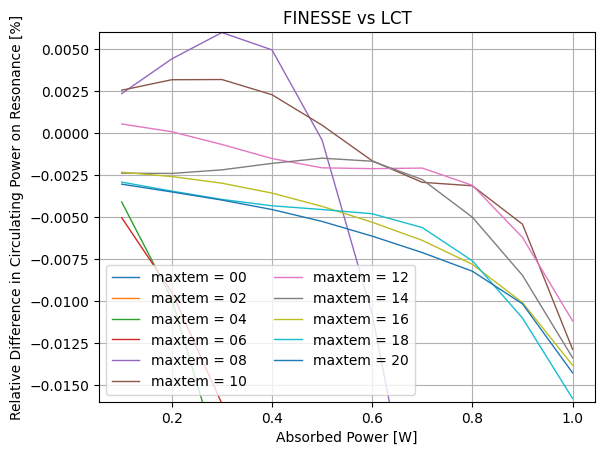

In [81]:
plt.plot(absorbed_power, maxtem00_relative*100, lw=1, ls='-', label='maxtem = 00')
plt.plot(absorbed_power, maxtem02_relative*100, lw=1, ls='-', label='maxtem = 02')
plt.plot(absorbed_power, maxtem04_relative*100, lw=1, ls='-', label='maxtem = 04')
plt.plot(absorbed_power, maxtem06_relative*100, lw=1, ls='-', label='maxtem = 06')
plt.plot(absorbed_power, maxtem08_relative*100, lw=1, ls='-', label='maxtem = 08')
plt.plot(absorbed_power, maxtem10_relative*100, lw=1, ls='-', label='maxtem = 10')
plt.plot(absorbed_power, maxtem12_relative*100, lw=1, ls='-', label='maxtem = 12')
plt.plot(absorbed_power, maxtem14_relative*100, lw=1, ls='-', label='maxtem = 14')
plt.plot(absorbed_power, maxtem16_relative*100, lw=1, ls='-', label='maxtem = 16')
plt.plot(absorbed_power, maxtem18_relative*100, lw=1, ls='-', label='maxtem = 18')
plt.plot(absorbed_power, maxtem20_relative*100, lw=1, ls='-', label='maxtem = 20')

plt.xlabel('Absorbed Power [W]')
plt.ylabel('Relative Difference in Circulating Power on Resonance [%]')
plt.title('FINESSE vs LCT')
plt.ylim(-0.016,0.006)
plt.grid(True)
plt.legend(ncol=2)
plt.savefig('Media/LCTvsFINESSE_relativecompzoom.jpg')
plt.show()

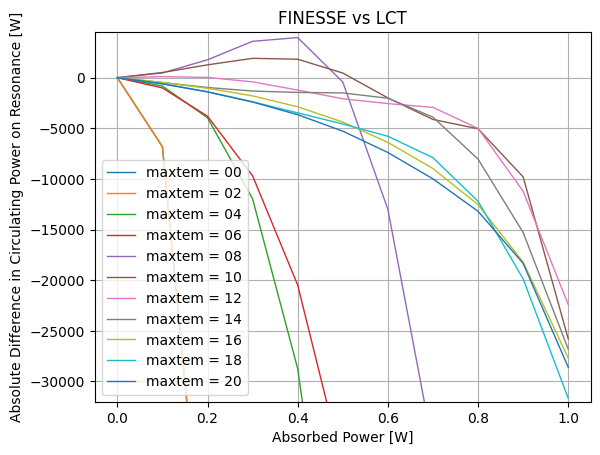

In [89]:
plt.plot(absorbed_power, maxtem00_absolute*100, lw=1, ls='-', label='maxtem = 00')
plt.plot(absorbed_power, maxtem02_absolute*100, lw=1, ls='-', label='maxtem = 02')
plt.plot(absorbed_power, maxtem04_absolute*100, lw=1, ls='-', label='maxtem = 04')
plt.plot(absorbed_power, maxtem06_absolute*100, lw=1, ls='-', label='maxtem = 06')
plt.plot(absorbed_power, maxtem08_absolute*100, lw=1, ls='-', label='maxtem = 08')
plt.plot(absorbed_power, maxtem10_absolute*100, lw=1, ls='-', label='maxtem = 10')
plt.plot(absorbed_power, maxtem12_absolute*100, lw=1, ls='-', label='maxtem = 12')
plt.plot(absorbed_power, maxtem14_absolute*100, lw=1, ls='-', label='maxtem = 14')
plt.plot(absorbed_power, maxtem16_absolute*100, lw=1, ls='-', label='maxtem = 16')
plt.plot(absorbed_power, maxtem18_absolute*100, lw=1, ls='-', label='maxtem = 18')
plt.plot(absorbed_power, maxtem20_absolute*100, lw=1, ls='-', label='maxtem = 20')

plt.xlabel('Absorbed Power [W]')
plt.ylabel('Absolute Difference in Circulating Power on Resonance [W]')
plt.title('FINESSE vs LCT')
plt.ylim(-32000,4500)
plt.grid(True)
plt.legend()
plt.savefig('Media/LCTvsFINESSE_absolutecompzoom.jpg')
plt.show()